# Improved U-Net Training Pipeline for Steel Defect Segmentation

This notebook provides a professional, end-to-end pipeline for training a U-Net model for semantic segmentation of steel surface defects. It incorporates best practices to improve model performance and robustness.

### Key Improvements:
1.  **Configuration Management**: Centralized hyperparameters in a `CFG` class.
2.  **Stratified K-Fold Cross-Validation**: Ensures balanced distribution of defected/non-defected images between training and validation sets.
3.  **Data Augmentation**: Uses `albumentations` for a rich set of image augmentations to improve model generalization.
4.  **Efficient Utilities**: Optimized RLE decoding and data handling.
5.  **Advanced Training Engine**: A `Trainer` class that includes:
    - **Learning Rate Scheduling** (`ReduceLROnPlateau`)
    - **Model Checkpointing** (saves the best model based on validation score)
    - **Early Stopping** (prevents overfitting and saves time)
    - `tqdm` progress bars for clear, real-time feedback.
6.  **Comprehensive Evaluation**: Calculates and displays key metrics (Dice, IoU, Precision, Recall) per class.
7.  **Visualization**: Includes functions to plot training history and visualize model predictions against ground truth masks.

## 1. Imports and Setup

In [1]:
import os
import gc
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.notebook import tqdm
from typing import List, Dict, Any, Tuple

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

## 2. Configuration

In [2]:
class CFG:
    # --- General ---
    SEED = 42
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    N_SPLITS = 5
    
    # --- Data ---
    DATA_DIR = './'
    TRAIN_IMG_DIR = os.path.join(DATA_DIR, 'train_images')
    TEST_IMG_DIR = os.path.join(DATA_DIR, 'test_images')
    CSV_PATH = os.path.join(DATA_DIR, 'train.csv')
    
    # --- Model ---
    MODEL_NAME = "Unet"
    ENCODER = "resnet34"
    ENCODER_WEIGHTS = "imagenet"
    NUM_CLASSES = 4
    ACTIVATION = None # Use None for logits output, as BCEWithLogitsLoss is used
    
    # --- Training ---
    IMG_HEIGHT = 128
    IMG_WIDTH = 800
    EPOCHS = 20 # Increased epochs, with early stopping
    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 32
    LR = 1e-4
    WEIGHT_DECAY = 1e-6
    SCHEDULER_PATIENCE = 3
    EARLY_STOPPING_PATIENCE = 5
    NUM_WORKERS = 0 if torch.cuda.is_available() else 0
    
    # --- Output ---
    MODEL_SAVE_PATH = f'{MODEL_NAME}-{ENCODER}-best.pth'

## 3. Data Preparation & Utilities

In [3]:
def set_seed(seed=42):
    '''Sets the seed for reproducibility.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)

def rle2mask(rle: str, shape: Tuple[int, int] = (256, 1600)) -> np.ndarray:
    '''
    Decodes a run-length encoded string into a binary mask.
    
    Args:
        rle (str): The RLE string.
        shape (tuple): The (height, width) of the original image.
        
    Returns:
        np.ndarray: A 2D binary mask.
    '''
    if pd.isnull(rle) or rle == '':
        return np.zeros(shape[0] * shape[1], dtype=np.uint8).reshape(shape)
    
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
        
    return img.reshape(shape, order='F')

def prepare_dataframe(csv_path: str) -> pd.DataFrame:
    # '''Prepares the dataframe by splitting ImageId_ClassId and pivoting.'''
    df = pd.read_csv('train.csv')
    # df[['ImageId', 'ClassId']] = df['ImageId_ClassId'].str.split('_', expand=True)
    df['ClassId'] = df['ClassId'].astype(int)
    df_pivot = df.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
    df_pivot.columns = [f'rle_{c}' for c in df_pivot.columns]
    df_pivot = df_pivot.reset_index()
    df_pivot['has_defect'] = (df_pivot.iloc[:, 1:].notna().sum(axis=1) > 0).astype(int)
    return df_pivot

set_seed(CFG.SEED)

## 4. Data Augmentations

We define separate augmentation pipelines for training and validation. Training augmentations introduce randomness to help the model generalize, while validation uses only necessary preprocessing.

In [4]:
def get_train_augs() -> A.Compose:
    return A.Compose([
        A.Resize(CFG.IMG_HEIGHT, CFG.IMG_WIDTH, always_apply=True),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=10, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

def get_valid_augs() -> A.Compose:
    return A.Compose([
        A.Resize(CFG.IMG_HEIGHT, CFG.IMG_WIDTH, always_apply=True),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

## 5. Dataset and Dataloaders

In [5]:
class SteelDataset(Dataset):
    def __init__(self, df: pd.DataFrame, data_path: str, transforms: A.Compose):
        self.df = df
        self.data_path = data_path
        self.transforms = transforms
        self.image_ids = self.df['ImageId'].values

    def __len__(self) -> int:
        return len(self.image_ids)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image_id = self.image_ids[idx]
        image_path = os.path.join(self.data_path, image_id)
        
        try:
            image = cv2.imread(image_path)
            if image is None: # Check if image was actually loaded
                raise FileNotFoundError(f"Image not found or corrupted at {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}. Returning placeholder image.")
            # Return a black placeholder image and empty masks to prevent crash
            image = np.zeros((CFG.IMG_HEIGHT, CFG.IMG_WIDTH, 3), dtype=np.uint8)
            masks = np.zeros((CFG.IMG_HEIGHT, CFG.IMG_WIDTH, CFG.NUM_CLASSES), dtype=np.float32)
            # Apply transforms even to placeholder to ensure tensor output
            augmented = self.transforms(image=image, mask=masks)
            return augmented['image'], augmented['mask'].permute(2, 0, 1)
        
        row = self.df[self.df['ImageId'] == image_id]
        masks = np.zeros((CFG.IMG_HEIGHT, CFG.IMG_WIDTH, CFG.NUM_CLASSES), dtype=np.float32)
        
        for i in range(CFG.NUM_CLASSES):
            rle = row[f'rle_{i+1}'].iloc[0]
            if isinstance(rle, str):
                try:
                    mask = rle2mask(rle, shape=(256, 1600)) # Original image shape for RLE decoding
                    mask = cv2.resize(mask, (CFG.IMG_WIDTH, CFG.IMG_HEIGHT), interpolation=cv2.INTER_NEAREST)
                    masks[..., i] = mask
                except Exception as e:
                    print(f"Warning: Error decoding RLE for {image_id}, Class {i+1}: {e}. Mask will be empty.")
                
        augmented = self.transforms(image=image, mask=masks)
        image = augmented['image']
        mask = augmented['mask'].permute(2, 0, 1) # (H, W, C) -> (C, H, W)
        
        return image, mask

## 6. Model, Loss, and Metrics

In [6]:
def build_model() -> nn.Module:
    '''Builds the U-Net model.'''
    model = smp.Unet(
        encoder_name=CFG.ENCODER,
        encoder_weights=CFG.ENCODER_WEIGHTS,
        in_channels=3,
        classes=CFG.NUM_CLASSES,
        activation=CFG.ACTIVATION
    )
    model.to(CFG.DEVICE)
    return model

class DiceBCELoss(nn.Module):
    '''Combined Dice and BCE Loss for segmentation.'''
    def __init__(self, weight=0.5, bce_weight=0.5):
        super(DiceBCELoss, self).__init__()
        self.bce_loss = nn.BCEWithLogitsLoss()
        self.dice_loss = smp.losses.DiceLoss(mode='multilabel', from_logits=True)
        self.weight = weight
        self.bce_weight = bce_weight

    def forward(self, inputs, targets):
        dice = self.dice_loss(inputs, targets)
        bce = self.bce_loss(inputs, targets)
        return self.weight * dice + self.bce_weight * bce

def dice_coef(y_true: torch.Tensor, y_pred: torch.Tensor, thr: float = 0.5, epsilon: float = 1e-7) -> float:
    '''Computes the Dice coefficient.'''
    y_pred = torch.sigmoid(y_pred) > thr
    y_true = y_true.to(torch.float32)
    y_pred = y_pred.to(torch.float32)
    
    intersection = (y_true * y_pred).sum()
    denominator = y_true.sum() + y_pred.sum()
    
    return ((2. * intersection + epsilon) / (denominator + epsilon)).item()

## 7. Training Engine

In [7]:
class Trainer:
    def __init__(self, model, optimizer, scheduler, criterion):
        self.model = model
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.criterion = criterion
        self.best_valid_dice = -1
        self.early_stopping_counter = 0
        self.history = {'train_loss': [], 'valid_loss': [], 'train_dice': [], 'valid_dice': []}

    def _run_epoch(self, dataloader, is_training=True):
        self.model.train() if is_training else self.model.eval()
        total_loss, total_dice = 0, 0
        
        print(f"DEBUG: Entering _run_epoch for {'training' if is_training else 'validation'}. Dataloader length: {len(dataloader)}")

        progress_bar = tqdm(dataloader, desc="Training" if is_training else "Validation")
        
        for batch_idx, (images, masks) in enumerate(progress_bar):
            # Added debug print to confirm batch processing
            if batch_idx == 0:
                print(f"DEBUG: First batch loaded successfully. Images shape: {images.shape}, Masks shape: {masks.shape}")

            images = images.to(CFG.DEVICE, dtype=torch.float)
            masks = masks.to(CFG.DEVICE, dtype=torch.float)

            with torch.set_grad_enabled(is_training):
                outputs = self.model(images)
                loss = self.criterion(outputs, masks)
                dice = dice_coef(masks, outputs)

                if is_training:
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

            total_loss += loss.item() * images.size(0)
            total_dice += dice * images.size(0)
            
            progress_bar.set_postfix(loss=f'{loss.item():.4f}', dice=f'{dice:.4f}')

        epoch_loss = total_loss / len(dataloader.dataset)
        epoch_dice = total_dice / len(dataloader.dataset)
        return epoch_loss, epoch_dice

    def fit(self, train_loader, valid_loader):
        for epoch in range(CFG.EPOCHS):
            print(f"\n{'='*20} Epoch: {epoch + 1} / {CFG.EPOCHS} {'='*20}")
            
            train_loss, train_dice = self._run_epoch(train_loader, is_training=True)
            valid_loss, valid_dice = self._run_epoch(valid_loader, is_training=False)

            self.history['train_loss'].append(train_loss)
            self.history['valid_loss'].append(valid_loss)
            self.history['train_dice'].append(train_dice)
            self.history['valid_dice'].append(valid_dice)
            
            print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
            print(f"Valid Loss: {valid_loss:.4f}, Valid Dice: {valid_dice:.4f}")

            self.scheduler.step(valid_dice)

            if valid_dice > self.best_valid_dice:
                print(f"Validation Dice improved from {self.best_valid_dice:.4f} to {valid_dice:.4f}. Saving model!")
                self.best_valid_dice = valid_dice
                self.early_stopping_counter = 0
                torch.save(self.model.state_dict(), CFG.MODEL_SAVE_PATH)
            else:
                self.early_stopping_counter += 1
                print(f"Validation Dice did not improve. Early stopping counter: {self.early_stopping_counter}")

            if self.early_stopping_counter >= CFG.EARLY_STOPPING_PATIENCE:
                print("Early stopping triggered!")
                break
            
            gc.collect()
            torch.cuda.empty_cache()

## 8. Main Execution Block


In [8]:
if __name__ == '__main__':
    print(f"DEBUG: Starting main execution block.")
    print(f"DEBUG: TRAIN_IMG_DIR: {CFG.TRAIN_IMG_DIR}")
    print(f"DEBUG: CSV_PATH: {CFG.CSV_PATH}")

    # Prepare Data
    df = prepare_dataframe(CFG.CSV_PATH)
    print(f"DEBUG: DataFrame prepared. Total unique images: {len(df)}")

    # Stratified K-Fold Split
    skf = StratifiedKFold(n_splits=CFG.N_SPLITS, shuffle=True, random_state=CFG.SEED)
    for fold, (train_idx, valid_idx) in enumerate(skf.split(df['ImageId'], df['has_defect'])):
        # We will train on the first fold only for this example
        if fold == 0:
            train_df = df.iloc[train_idx]
            valid_df = df.iloc[valid_idx]
            break

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(valid_df)}")

    # Create Datasets and Dataloaders
    # print(f"DEBUG: Initializing train_dataset with {len(train_df)} samples.")
    train_dataset = SteelDataset(train_df, CFG.TRAIN_IMG_DIR, get_train_augs())
    # print(f"DEBUG: Initializing valid_dataset with {len(valid_df)} samples.")
    valid_dataset = SteelDataset(valid_df, CFG.TRAIN_IMG_DIR, get_valid_augs())

    # print(f"DEBUG: Initializing train_loader (batch_size={CFG.TRAIN_BATCH_SIZE}, num_workers={CFG.NUM_WORKERS}).")
    train_loader = DataLoader(train_dataset, batch_size=CFG.TRAIN_BATCH_SIZE, shuffle=True, num_workers=CFG.NUM_WORKERS, pin_memory=True)
    # print(f"DEBUG: Initializing valid_loader (batch_size={CFG.VALID_BATCH_SIZE}, num_workers={CFG.NUM_WORKERS}).")
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.VALID_BATCH_SIZE, shuffle=False, num_workers=CFG.NUM_WORKERS, pin_memory=True)

    # Initialize Model and Training Components
    print(f"DEBUG: Building model on device: {CFG.DEVICE}")
    model = build_model()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LR, weight_decay=CFG.WEIGHT_DECAY)
    # Corrected: Removed 'verbose=True' as it's deprecated/removed in newer PyTorch versions
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=CFG.SCHEDULER_PATIENCE)
    criterion = DiceBCELoss()

    # Train the model
    print(f"DEBUG: Starting trainer.fit()...")
    trainer = Trainer(model, optimizer, scheduler, criterion)
    history = trainer.fit(train_loader, valid_loader)

DEBUG: Starting main execution block.
DEBUG: TRAIN_IMG_DIR: ./train_images
DEBUG: CSV_PATH: ./train.csv
DEBUG: DataFrame prepared. Total unique images: 6666
Training set size: 5332
Validation set size: 1334
DEBUG: Initializing train_dataset with 5332 samples.
DEBUG: Initializing valid_dataset with 1334 samples.
DEBUG: Initializing train_loader (batch_size=16, num_workers=0).
DEBUG: Initializing valid_loader (batch_size=32, num_workers=0).
DEBUG: Building model on device: cuda
DEBUG: Starting trainer.fit()...

==================== Epoch: 1 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.5858, Train Dice: 0.1958
Valid Loss: 0.5358, Valid Dice: 0.5080
Validation Dice improved from -1.0000 to 0.5080. Saving model!

==================== Epoch: 2 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.4158, Train Dice: 0.5748
Valid Loss: 0.4216, Valid Dice: 0.6652
Validation Dice improved from 0.5080 to 0.6652. Saving model!

==================== Epoch: 3 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.3328, Train Dice: 0.6204
Valid Loss: 0.3620, Valid Dice: 0.6531
Validation Dice did not improve. Early stopping counter: 1

==================== Epoch: 4 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2880, Train Dice: 0.6399
Valid Loss: 0.2961, Valid Dice: 0.6923
Validation Dice improved from 0.6652 to 0.6923. Saving model!

==================== Epoch: 5 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2400, Train Dice: 0.6620
Valid Loss: 0.2812, Valid Dice: 0.6839
Validation Dice did not improve. Early stopping counter: 1

==================== Epoch: 6 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2397, Train Dice: 0.6400
Valid Loss: 0.2783, Valid Dice: 0.6632
Validation Dice did not improve. Early stopping counter: 2

==================== Epoch: 7 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2262, Train Dice: 0.6620
Valid Loss: 0.2527, Valid Dice: 0.7226
Validation Dice improved from 0.6923 to 0.7226. Saving model!

==================== Epoch: 8 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2168, Train Dice: 0.6787
Valid Loss: 0.2507, Valid Dice: 0.7201
Validation Dice did not improve. Early stopping counter: 1

==================== Epoch: 9 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2156, Train Dice: 0.6912
Valid Loss: 0.2406, Valid Dice: 0.7272
Validation Dice improved from 0.7226 to 0.7272. Saving model!

==================== Epoch: 10 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2147, Train Dice: 0.6834
Valid Loss: 0.2473, Valid Dice: 0.7099
Validation Dice did not improve. Early stopping counter: 1

==================== Epoch: 11 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2084, Train Dice: 0.6937
Valid Loss: 0.2409, Valid Dice: 0.7320
Validation Dice improved from 0.7272 to 0.7320. Saving model!

==================== Epoch: 12 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2136, Train Dice: 0.6906
Valid Loss: 0.2468, Valid Dice: 0.7284
Validation Dice did not improve. Early stopping counter: 1

==================== Epoch: 13 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2034, Train Dice: 0.7044
Valid Loss: 0.2450, Valid Dice: 0.7182
Validation Dice did not improve. Early stopping counter: 2

==================== Epoch: 14 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2068, Train Dice: 0.7017
Valid Loss: 0.2373, Valid Dice: 0.7389
Validation Dice improved from 0.7320 to 0.7389. Saving model!

==================== Epoch: 15 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2063, Train Dice: 0.7050
Valid Loss: 0.2385, Valid Dice: 0.7327
Validation Dice did not improve. Early stopping counter: 1

==================== Epoch: 16 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.1989, Train Dice: 0.7145
Valid Loss: 0.2421, Valid Dice: 0.7218
Validation Dice did not improve. Early stopping counter: 2

==================== Epoch: 17 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.2017, Train Dice: 0.7119
Valid Loss: 0.2344, Valid Dice: 0.7286
Validation Dice did not improve. Early stopping counter: 3

==================== Epoch: 18 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.1941, Train Dice: 0.7097
Valid Loss: 0.2167, Valid Dice: 0.7276
Validation Dice did not improve. Early stopping counter: 4

==================== Epoch: 19 / 20 ====================
DEBUG: Entering _run_epoch for training. Dataloader length: 334


Training:   0%|          | 0/334 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([16, 3, 128, 800]), Masks shape: torch.Size([16, 4, 128, 800])
DEBUG: Entering _run_epoch for validation. Dataloader length: 42


Validation:   0%|          | 0/42 [00:00<?, ?it/s]

DEBUG: First batch loaded successfully. Images shape: torch.Size([32, 3, 128, 800]), Masks shape: torch.Size([32, 4, 128, 800])
Train Loss: 0.1767, Train Dice: 0.7256
Valid Loss: 0.2053, Valid Dice: 0.7387
Validation Dice did not improve. Early stopping counter: 5
Early stopping triggered!


## 9. Evaluation and Visualization

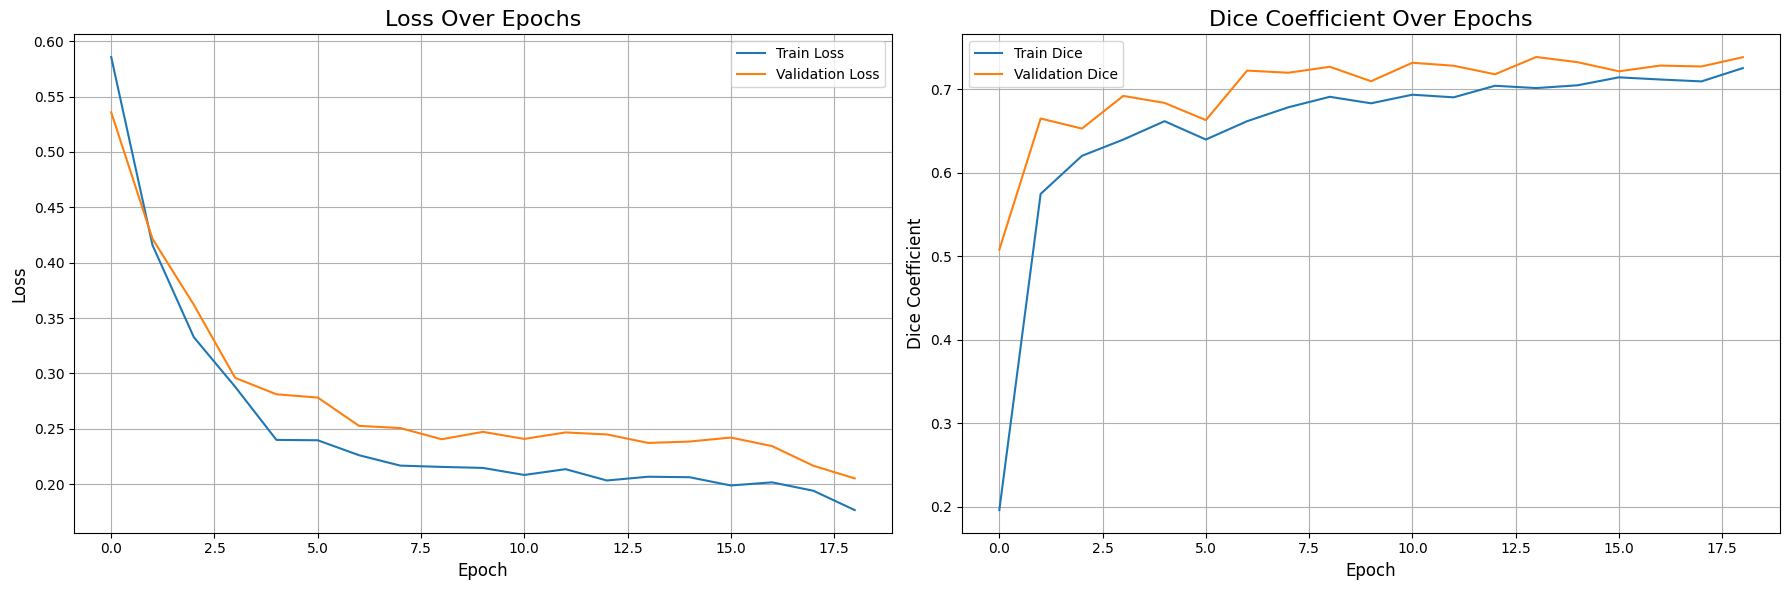

In [9]:
def plot_history(history: Dict[str, List[float]]):
    '''Plots training and validation loss and dice scores.'''
    plt.figure(figsize=(18, 6))
    
    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['valid_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Dice Plot
    plt.subplot(1, 2, 2)
    plt.plot(history['train_dice'], label='Train Dice')
    plt.plot(history['valid_dice'], label='Validation Dice')
    plt.title('Dice Coefficient Over Epochs', fontsize=16)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Dice Coefficient', fontsize=12)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_history(trainer.history)

In [10]:
def evaluate_model(model: nn.Module, dataloader: DataLoader, threshold: float = 0.5):
    '''Evaluates the model on a dataset and prints classification metrics.'''
    model.eval()
    all_preds, all_trues = [], []
    
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating"):
            images = images.to(CFG.DEVICE, dtype=torch.float)
            
            outputs = model(images)
            preds = (torch.sigmoid(outputs) > threshold).cpu().numpy().astype(int)
            trues = masks.numpy().astype(int)
            
            # Flatten per-class masks for metric calculation
            all_preds.append(preds.reshape(-1, CFG.NUM_CLASSES))
            all_trues.append(trues.reshape(-1, CFG.NUM_CLASSES))
    
    preds_flat = np.vstack(all_preds)
    trues_flat = np.vstack(all_trues)

    print("\n--- Pixel-wise Evaluation Metrics ---")
    for i in range(CFG.NUM_CLASSES):
        print(f"\n📌 Defect Class {i+1}")
        precision = precision_score(trues_flat[:, i], preds_flat[:, i], zero_division=0)
        recall = recall_score(trues_flat[:, i], preds_flat[:, i], zero_division=0)
        f1 = f1_score(trues_flat[:, i], preds_flat[:, i], zero_division=0)
        iou = jaccard_score(trues_flat[:, i], preds_flat[:, i], zero_division=0)
        
        print(f"  Precision : {precision:.4f}")
        print(f"  Recall    : {recall:.4f}")
        print(f"  F1-score  : {f1:.4f}")
        print(f"  IoU (Jaccard) : {iou:.4f}")

# Load the best model and evaluate on the validation set
best_model = build_model()
best_model.load_state_dict(torch.load(CFG.MODEL_SAVE_PATH))
evaluate_model(best_model, valid_loader)

Evaluating:   0%|          | 0/42 [00:00<?, ?it/s]


--- Pixel-wise Evaluation Metrics ---

📌 Defect Class 1
  Precision : 0.7334
  Recall    : 0.7597
  F1-score  : 0.7463
  IoU (Jaccard) : 0.5953

📌 Defect Class 2
  Precision : 0.7342
  Recall    : 0.7569
  F1-score  : 0.7454
  IoU (Jaccard) : 0.5941

📌 Defect Class 3
  Precision : 0.7323
  Recall    : 0.7591
  F1-score  : 0.7454
  IoU (Jaccard) : 0.5942

📌 Defect Class 4
  Precision : 0.7326
  Recall    : 0.7581
  F1-score  : 0.7451
  IoU (Jaccard) : 0.5938


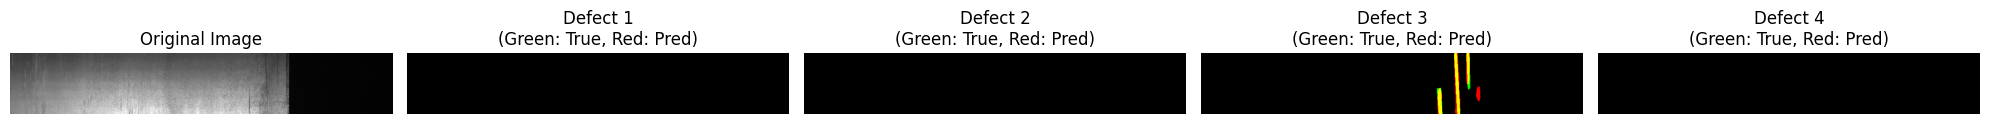

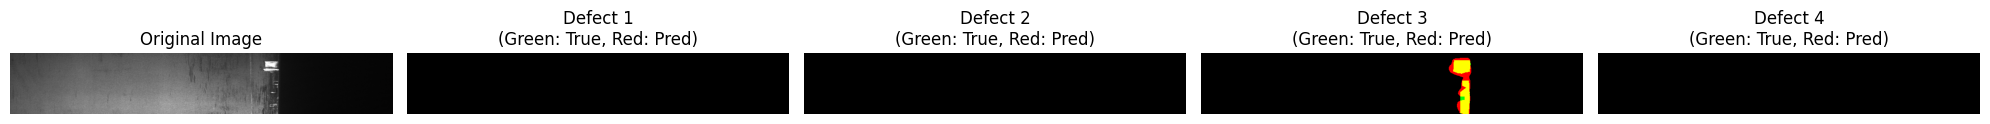

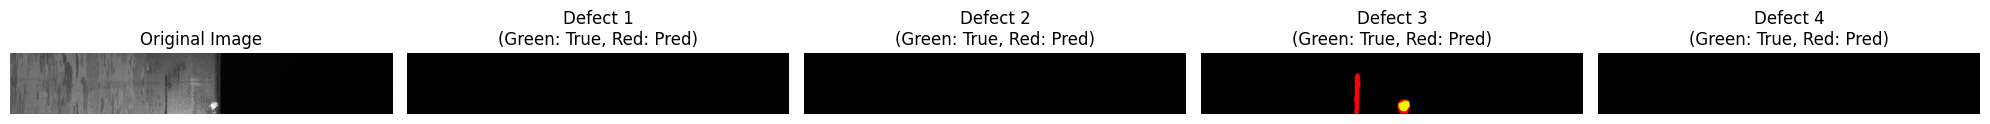

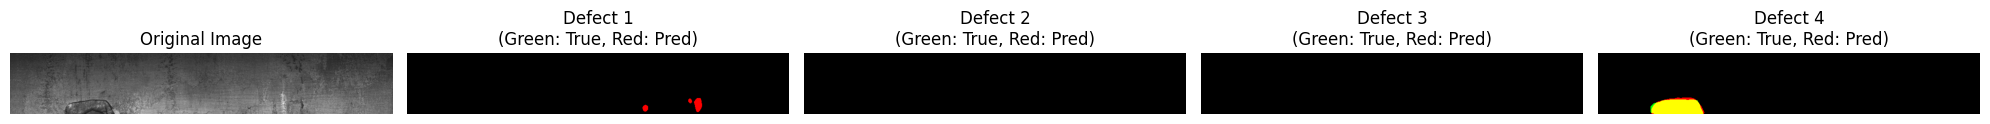

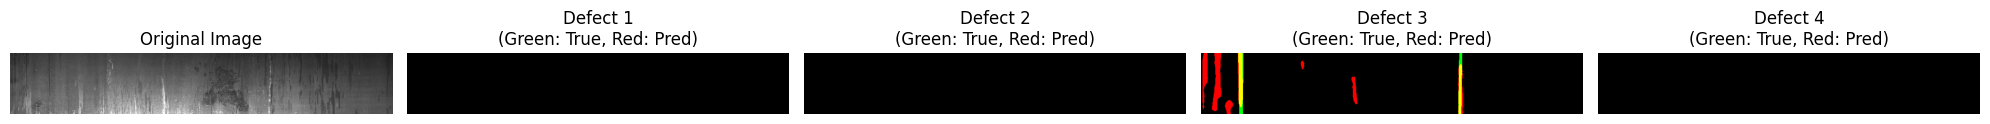

In [11]:
def visualize_predictions(model: nn.Module, dataset: Dataset, num_samples: int = 5):
    '''Visualizes model predictions on a few samples from the dataset.'''
    model.eval()
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx in indices:
        image, mask_true = dataset[idx]
        image_vis = image.permute(1, 2, 0).numpy() # For visualization
        image_vis = (image_vis * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]) # Un-normalize
        image_vis = np.clip(image_vis, 0, 1)
        
        with torch.no_grad():
            image_tensor = image.unsqueeze(0).to(CFG.DEVICE, dtype=torch.float)
            output = model(image_tensor)
            mask_pred = (torch.sigmoid(output) > 0.5).squeeze(0).cpu().numpy()

        fig, axes = plt.subplots(1, CFG.NUM_CLASSES + 1, figsize=(20, 5))
        axes[0].imshow(image_vis)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        for i in range(CFG.NUM_CLASSES):
            ax = axes[i+1]
            combined_mask = np.zeros((CFG.IMG_HEIGHT, CFG.IMG_WIDTH, 3))
            combined_mask[..., 0] = mask_pred[i] # Red channel for prediction
            combined_mask[..., 1] = mask_true[i] # Green channel for ground truth
            ax.imshow(combined_mask)
            ax.set_title(f"Defect {i+1}\n(Green: True, Red: Pred)")
            ax.axis('off')
            
        plt.tight_layout()
        plt.show()

# Visualize on validation data
visualize_predictions(best_model, valid_dataset)